In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=30

In [3]:
print(tf.__version__)

2.14.0


In [4]:
dataset=tf.keras.utils.image_dataset_from_directory(
    "training",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 3251 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [6]:
# Get a batch of images and labels
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 1 0 0 2 0 0 2 2 0 2 0 0 2 0 0 0 2 2 2 1 0 0 2 2 0 1 0 0 1 0]


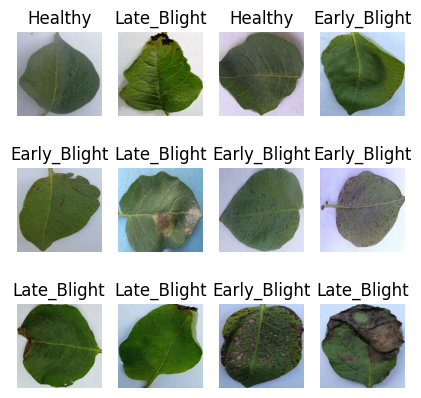

In [7]:
# Create a figure
plt.figure(figsize=(5, 5))

# Plot the images in a 3x4 grid
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

plt.show()

In [9]:
len(dataset)

102

In [10]:
#we have this many images
102*32

3264

In [8]:
def get_dataset_partition_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, buffer_size=2048):
    assert((train_split+test_split+val_split)==1)
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle( buffer_size, seed=123 )
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

    

In [9]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [13]:
len(train_ds)

81

In [14]:
len(val_ds)

10

In [15]:
len(test_ds)

11

In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[169. 195. 230.]
  [169. 195. 230.]
  [169. 195. 230.]
  ...
  [173. 197. 233.]
  [173. 197. 233.]
  [173. 197. 233.]]

 [[168. 194. 229.]
  [168. 194. 229.]
  [168. 194. 229.]
  ...
  [172. 196. 232.]
  [172. 196. 232.]
  [172. 196. 232.]]

 [[168. 194. 229.]
  [168. 194. 229.]
  [168. 194. 229.]
  ...
  [172. 196. 232.]
  [172. 196. 232.]
  [172. 196. 232.]]

 ...

 [[139. 164. 205.]
  [139. 164. 205.]
  [139. 164. 205.]
  ...
  [139. 168. 212.]
  [139. 168. 212.]
  [139. 168. 212.]]

 [[139. 164. 205.]
  [139. 164. 205.]
  [139. 164. 205.]
  ...
  [139. 168. 212.]
  [139. 168. 212.]
  [139. 168. 212.]]

 [[139. 164. 205.]
  [139. 164. 205.]
  [139. 164. 205.]
  ...
  [139. 168. 212.]
  [139. 168. 212.]
  [139. 168. 212.]]]


In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [13]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [14]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [17]:
history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/30
81/81 [==============================] - 112s 1s/step - loss: 1.0562 - accuracy: 0.4157 - val_loss: 1.0026 - val_accuracy: 0.4969
Epoch 2/30
81/81 [==============================] - 103s 1s/step - loss: 0.9334 - accuracy: 0.5684 - val_loss: 0.6876 - val_accuracy: 0.7125
Epoch 3/30
81/81 [==============================] - 97s 1s/step - loss: 0.7324 - accuracy: 0.6968 - val_loss: 0.6486 - val_accuracy: 0.7469
Epoch 4/30
81/81 [==============================] - 96s 1s/step - loss: 0.6342 - accuracy: 0.7464 - val_loss: 0.5067 - val_accuracy: 0.8062
Epoch 5/30
81/81 [==============================] - 95s 1s/step - loss: 0.5320 - accuracy: 0.7949 - val_loss: 0.4219 - val_accuracy: 0.8438
Epoch 6/30
81/81 [==============================] - 94s 1s/step - loss: 0.3709 - accuracy: 0.8631 - val_loss: 0.3525 - val_accuracy: 0.8562
Epoch 7/30
81/81 [==============================] - 94s 1s/step - loss: 0.3730 - accuracy: 0.8554 - val_loss: 0.2967 - val_accuracy: 0.8969
Epoch 8/30
81/81 [

In [18]:
score=model.evaluate(test_ds)

11/11 [==============================] - 14s 287ms/step - loss: 0.1078 - accuracy: 0.9659


In [19]:
score

[0.10783123224973679, 0.9659090638160706]

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'training and validation loss')

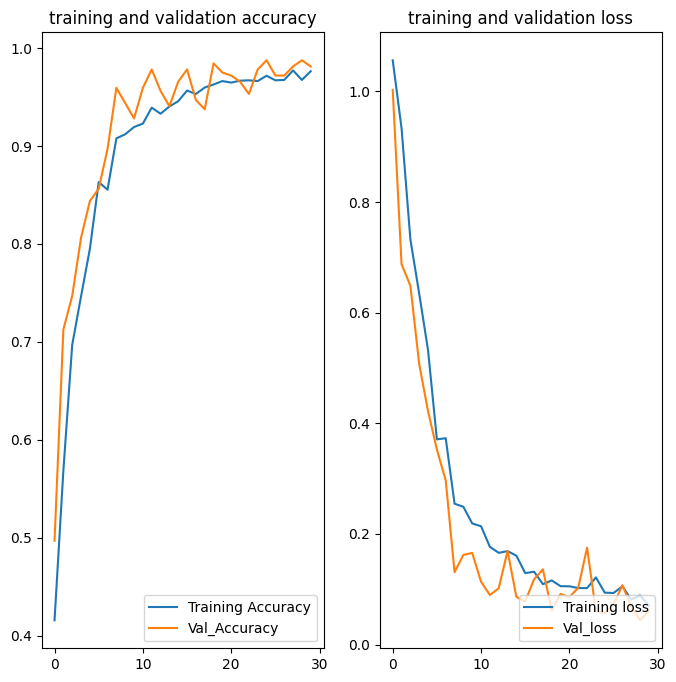

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title("training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label='Val_loss')
plt.legend(loc='lower right')
plt.title("training and validation loss")

First img to predict
1/1 [==============================] - 1s 802ms/step
Early_Blight


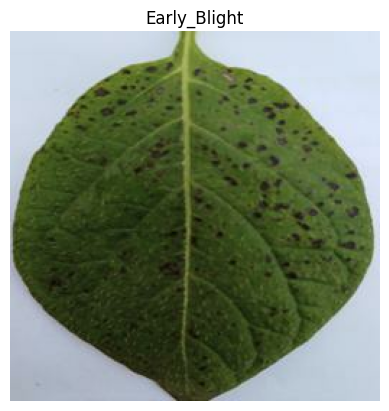

In [22]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    print("First img to predict")
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    batch_prediction = model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

plt.show()

In [23]:
import numpy as np
def predict_one(model,img):
    img_array= tf.keras.utils.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 43ms/step


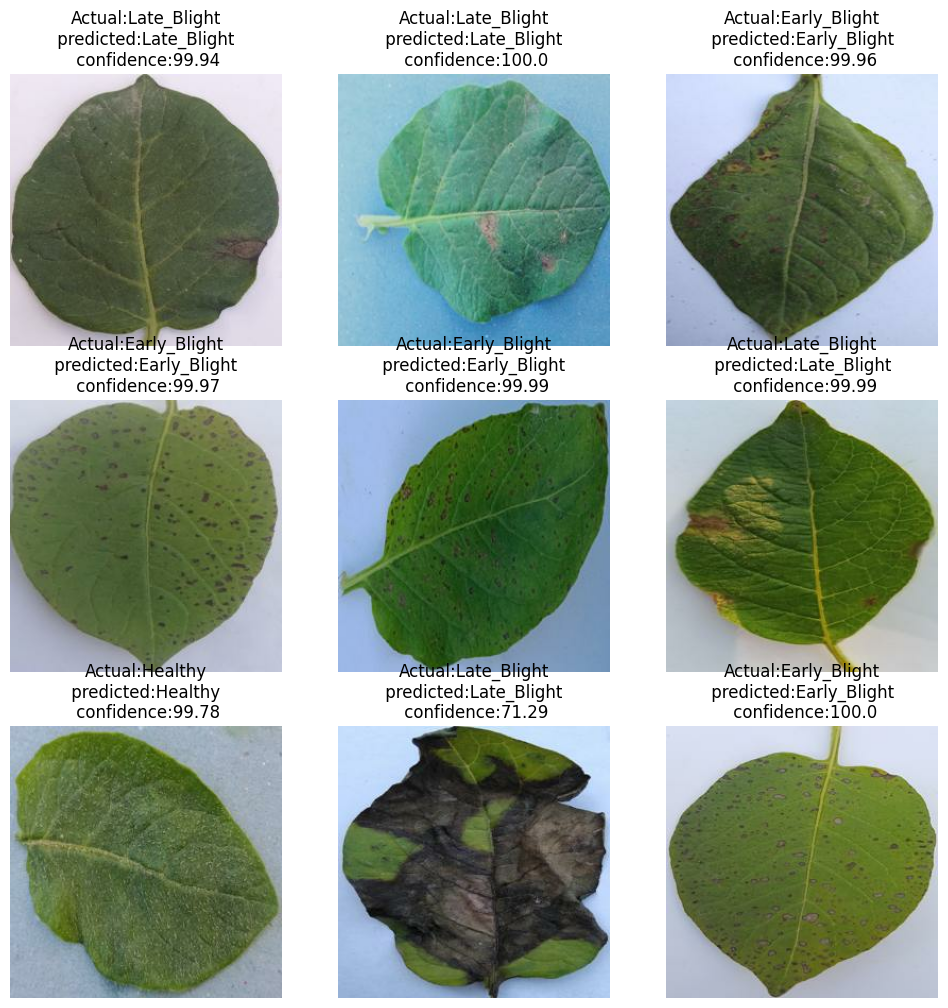

In [24]:
plt.figure(figsize=(12,12))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict_one(model,images[i])
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class}\n predicted:{predicted_class} \n confidence:{confidence}")
        plt.axis("off")
        
        

In [ ]:
modelver = 2
model.export(f"./models/{modelver}") #to save in savemodel format

In [31]:
modelver = 1
model.save(f"./models-served/{modelver}.keras") 